/home/leon/Documentos/UNSA/IA/articulo-ia/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


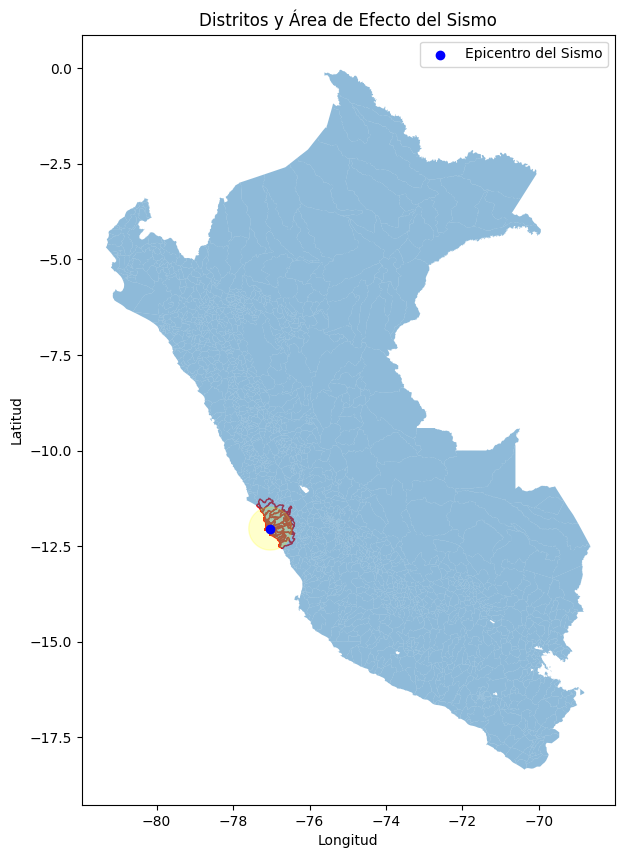

,NOMBDIST,NOMBPROV,NOMBDEP,Distancia al Epicentro (km),POBLACION
161,LIMA,LIMA,LIMA,2.426336,293647.0
162,MIRAFLORES,LIMA,LIMA,8.586319,114188.0
163,MAGDALENA DEL MAR,LIMA,LIMA,7.081693,67156.0
164,SAN LUIS,LIMA,LIMA,4.801311,59084.0
165,SANTA ANITA,LIMA,LIMA,7.076129,221039.0


In [6]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape, Point
from geopy.distance import geodesic

# 1. Cargar el archivo CSV
df = pd.read_csv('poblacion.csv', sep=';')

# 2. Crear una función para convertir GeoJSON a geometría Shapely
def convert_geojson_to_geometry(geojson_string):
    return shape(eval(geojson_string))

# 3. Aplicar la función para convertir GeoJSON a geometrías Shapely y crear un GeoDataFrame
df['geometry'] = df['Geo Shape'].apply(convert_geojson_to_geometry)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 4. Definir el epicentro del sismo (ejemplo)
epicentro_lon = -77.02824

epicentro_lat =  -12.04318
epicentro = Point(epicentro_lon, epicentro_lat)

# 5. Calcular el radio de impacto del sismo (ejemplo)
magnitud_momento = 7.0
profundidad = 10  # en kilómetros
R = (10 ** (0.5 * magnitud_momento - 1.75)  * profundidad ) / 1000
# 6. Crear un buffer circular alrededor del epicentro del sismo
area_de_efecto = epicentro.buffer(R)
distritos_en_area_efecto = gdf[gdf['geometry'].intersects(area_de_efecto)]

# 8. Calcular la distancia geodésica desde el epicentro a cada distrito afectado
def calcular_distancia(geometry, epicentro):
    centroide_distrito = geometry.centroid
    distancia = geodesic((epicentro.y, epicentro.x), (centroide_distrito.y, centroide_distrito.x)).kilometers
    return distancia

distritos_en_area_efecto['Distancia al Epicentro (km)'] = distritos_en_area_efecto['geometry'].apply(lambda geom: calcular_distancia(geom, epicentro))

# 9. Mostrar los distritos afectados con sus respectivas distancias al epicentro
#print("Distritos dentro del área de efecto del sismo y su distancia al epicentro:")
#print(distritos_en_area_efecto[['NOMBDIST', 'NOMBPROV', 'NOMBDEP', 'Distancia al Epicentro (km)']])

# 10. Guardar la figura como archivo PNG para visualizar más tarde
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plotear los distritos que intersectan con el área de efecto
distritos_en_area_efecto.plot(ax=ax, edgecolor='red', facecolor='none')

# Plotear todos los distritos en transparencia
gdf.plot(ax=ax, alpha=0.5)

# Plotear el área de efecto del sismo
x, y = area_de_efecto.exterior.xy
ax.fill(x, y, alpha=0.2, color='yellow')

# Plotear el epicentro del sismo
ax.scatter(epicentro_lon, epicentro_lat, color='blue', label='Epicentro del Sismo', zorder=5)

# Configuración adicional del gráfico
ax.set_title('Distritos y Área de Efecto del Sismo')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend()

# Guardar la figura como archivo PNG
plt.savefig('distritos_area_efecto_sismo.png', dpi=300)  # ajusta dpi según necesites para mayor resolución

# Mostrar el gráfico
plt.show()

# Mostrar las primeras filas para verificar
distritos_en_area_efecto[['NOMBDIST', 'NOMBPROV', 'NOMBDEP', 'Distancia al Epicentro (km)', 'POBLACION']].head()

In [2]:
distritos_en_area_efecto.columns

Index(['Geo Point', 'Geo Shape', 'CCDD', 'NOMBDEP', 'CCPP', 'NOMBPROV', 'CCDI',
       'NOMBDIST', 'CAPITAL', 'UBIGEO', 'IDPROV', 'CODIGO', 'CNT_CCPP',
       'DESCRIPCIO', 'POBLACION', 'FECHA', 'DAT_POB', 'geometry',
       'Distancia al Epicentro (km)'],
      dtype='object')

In [11]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Definir las variables difusas
magnitud = ctrl.Antecedent(np.arange(0, 10.1, 0.1), 'magnitud')
profundidad = ctrl.Antecedent(np.arange(0, 700.1, 1), 'profundidad')
distancia = ctrl.Antecedent(np.arange(0, 500.1, 1), 'distancia')
poblacion = ctrl.Antecedent(np.arange(0, 100000.1, 1000), 'poblacion')
riesgo = ctrl.Consequent(np.arange(0, 101, 1), 'riesgo')

# Definir los conjuntos difusos
magnitud['baja'] = fuzz.trapmf(magnitud.universe, [0, 3.5, 4.5, 5.0])
magnitud['moderada'] = fuzz.trapmf(magnitud.universe, [4.0, 5.0, 5.5, 6.5])
magnitud['alta'] = fuzz.trapmf(magnitud.universe, [6.0, 7.5, 8.5, 10])

profundidad['superficial'] = fuzz.trapmf(profundidad.universe, [0, 15, 20, 30])
profundidad['intermedia'] = fuzz.trapmf(profundidad.universe, [25, 40, 60, 80])
profundidad['profunda'] = fuzz.trapmf(profundidad.universe, [70, 100 , 200, 700])

distancia['cerca'] = fuzz.trapmf(distancia.universe, [0, 20, 40, 60])
distancia['media'] = fuzz.trapmf(distancia.universe, [50, 70, 120, 150])
distancia['lejos'] = fuzz.trapmf(distancia.universe, [130, 200, 350, 600])

poblacion['baja'] = fuzz.trapmf(poblacion.universe, [0, 1000, 9000, 11000])
poblacion['media'] = fuzz.trapmf(poblacion.universe, [10000, 15000, 45000, 55000])
poblacion['alta'] = fuzz.trapmf(poblacion.universe, [50000, 60000, 100000, 3000000])

riesgo['bajo'] = fuzz.trapmf(riesgo.universe, [10, 20, 30, 40])
riesgo['medio'] = fuzz.trapmf(riesgo.universe, [20, 40, 60, 70])
riesgo['alto'] = fuzz.trapmf(riesgo.universe, [60, 80, 100, 100])

# Definir las reglas difusas
rule1 = ctrl.Rule(magnitud['alta'] & profundidad['superficial'] & distancia['cerca'] & poblacion['alta'], riesgo['alto'])
rule2 = ctrl.Rule(magnitud['alta'] & profundidad['superficial'] & distancia['cerca'] & poblacion['media'], riesgo['alto'])
rule3 = ctrl.Rule(magnitud['moderada'] & profundidad['superficial'] & distancia['media'] & poblacion['alta'], riesgo['alto'])
rule4 = ctrl.Rule(magnitud['baja'] & profundidad['profunda'] & distancia['lejos'] & poblacion['baja'], riesgo['bajo'])
rule5 = ctrl.Rule(magnitud['alta'] & profundidad['intermedia'] & distancia['media'] & poblacion['alta'], riesgo['medio'])
rule6 = ctrl.Rule(magnitud['moderada'] & profundidad['intermedia'] & distancia['media'] & poblacion['media'], riesgo['medio'])
rule7 = ctrl.Rule(magnitud['alta'] & profundidad['superficial'] & distancia['media'] & poblacion['baja'], riesgo['medio'])
rule8 = ctrl.Rule(magnitud['moderada'] & profundidad['superficial'] & distancia['cerca'] & poblacion['baja'], riesgo['medio'])
rule9 = ctrl.Rule(magnitud['alta'] & profundidad['intermedia'] & distancia['cerca'] & poblacion['alta'], riesgo['alto'])
rule10 = ctrl.Rule(magnitud['moderada'] & profundidad['superficial'] & distancia['lejos'] & poblacion['media'], riesgo['medio'])
rule11 = ctrl.Rule(magnitud['baja'] & profundidad['superficial'] & distancia['cerca'] & poblacion['baja'], riesgo['bajo'])
rule12 = ctrl.Rule(magnitud['alta'] & profundidad['profunda'] & distancia['lejos'] & poblacion['alta'], riesgo['medio'])
rule13 = ctrl.Rule(magnitud['moderada'] & profundidad['profunda'] & distancia['media'] & poblacion['media'], riesgo['medio'])
rule14 = ctrl.Rule(magnitud['alta'] & profundidad['superficial'] & distancia['cerca'] & poblacion['baja'], riesgo['alto'])
rule15 = ctrl.Rule(magnitud['moderada'] & profundidad['intermedia'] & distancia['media'] & poblacion['baja'], riesgo['medio'])
rule16 = ctrl.Rule(magnitud['alta'] & profundidad['intermedia'] & distancia['lejos'] & poblacion['media'], riesgo['medio'])
rule17 = ctrl.Rule(magnitud['moderada'] & profundidad['superficial'] & distancia['cerca'] & poblacion['alta'], riesgo['alto'])
rule18 = ctrl.Rule(magnitud['baja'] & profundidad['intermedia'] & distancia['cerca'] & poblacion['media'], riesgo['bajo'])
rule19 = ctrl.Rule(magnitud['alta'] & profundidad['superficial'] & distancia['cerca'] & poblacion['alta'], riesgo['alto'])
rule20 = ctrl.Rule(magnitud['alta'] & profundidad['superficial'] & distancia['media'] & poblacion['alta'], riesgo['alto'])

# Crear el sistema de control
risk_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11, rule12, rule13, rule14, rule15, rule16, rule17, rule18, rule19, rule20])
risk = ctrl.ControlSystemSimulation(risk_ctrl)

# Función para calcular el riesgo
def calcular_riesgo(magnitud_sismo, profundidad_sismo, distancia_epicentro, poblacion):
    risk.input['magnitud'] = magnitud_sismo
    risk.input['profundidad'] = profundidad_sismo
    risk.input['distancia'] = distancia_epicentro
    risk.input['poblacion'] = poblacion
    risk.compute()
    return risk.output['riesgo']

# Asignar los valores de magnitud y profundidad del sismo
magnitud_sismo = 7
profundidad_sismo = 10

# Calcular el riesgo para cada distrito
distritos_en_area_efecto['Riesgo'] = distritos_en_area_efecto.apply(
    lambda row: calcular_riesgo(magnitud_sismo, profundidad_sismo, row['Distancia al Epicentro (km)'], row['POBLACION']),
    axis=1
)

print(distritos_en_area_efecto[['NOMBDIST','Distancia al Epicentro (km)', 'POBLACION', 'Riesgo']])


ValueError: Crisp output cannot be calculated, likely because the system is too sparse. Check to make sure this set of input values will activate at least one connected Term in each Antecedent via the current set of Rules.